In [2]:
import librosa
import librosa.display

import cv2
import os

import numpy as np
import matplotlib.pyplot as plt
cv2.__version__

'4.5.5'

In [3]:
filename = 'Tears_of_a_witch_SFA.wav'
y,sr = librosa.load(filename)
print(y.shape, sr)

(3424768,) 22050


In [4]:
onset_env = librosa.onset.onset_strength(y=y, sr=sr)

# Run the default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

# dynamic tempo
dtempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr,
                            aggregate=None)

Estimated tempo: 117.45 beats per minute


In [5]:
hop_len = 512
freq_w = 3
octave = 7

C = librosa.cqt(y, sr=sr, hop_length= hop_len, n_bins= 12*freq_w*octave, bins_per_octave= 12*freq_w)
C_db = librosa.amplitude_to_db(np.abs(C),ref=np.max)+80
c_compression = (C_db/80*255).astype(np.uint8)
print(C_db.shape)
print(c_compression.min(),c_compression.max())

(252, 6690)
0 255


In [6]:
gaussian_mask = np.array([[1/16,1/8,1/16], [1/8,1/4,1/8], [1/16,1/8,1/16]])
sharpening_mask1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpening_mask2 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

In [7]:
def nothing(pos):
    pass

def working():
    cv2.destroyAllWindows()
    raise NotImplementedError    

def gaussian(source):
    gaussian_mask = np.array([[1/16,1/8,1/16], [1/8,1/4,1/8], [1/16,1/8,1/16]])
    result = cv2.filter2D(source,-1,gaussian_mask)
    print("Gaussian filter")
    return result

def sharpening1(source):
    sharpening_mask1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    result = cv2.filter2D(source,-1,sharpening_mask1)
    print("8 connected sharpening")
    return result

def sharpening2(source):
    sharpening_mask2 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    result = cv2.filter2D(source,-1,sharpening_mask2)
    print("4 connected sharpening")
    return result

def stretching(source,pos):
    i_min = pos
    i_max = source.max()
    result = (255/(i_max-i_min)*(source-i_min)).astype(np.uint8)
    print("stretching")
    return result

def n_under0(source, pos):
    source[source<=pos]=0
    print("%d under 0"%pos)
    return source

def div(source, pos):
    source = (source*(pos/255)).astype(np.uint8)
    print("%d div_fn"%pos/255)
    return source

def value_up(source, pos):
    h,w = source.shape[:2]
    a = np.ones((h,w),np.uint8)*pos
    source = cv2.add(source,a)
    print("up shift %d"%pos)
    return source
    
    

def fn_log_write(log,fn,pos=None):
    if pos is None:
        log.append(fn)
    else:
        log.append((fn,pos))
    return log

def auto_fn(src,log):
    for kw in log:
        if type(kw) is tuple:
            src = kw_fn(kw[0],src,kw[1])
        else:
            src = kw_fn(kw,src)            
    return src

def kw_fn(kw,src,pos=None,log=None):
    if kw==ord('0'):
        src = n_under0(src,pos)
    elif kw==ord('t'):
        src = stretching(src,pos)
    elif kw==ord('g'):
        src = gaussian(src)
    elif kw==ord('1'):
        src = sharpening1(src)
    elif kw==ord('2'):
        src = sharpening2(src)
    elif kw==ord('d'):
        src = div(src,pos)
    elif kw==ord('u'):
        src = value_up(src,pos)

    if log is None:
        return src
    else:
        log = fn_log_write(log,kw,pos)
        return src, log
    
def iskw(kw):
    kw_fn_list =[
        ord('0'),ord('t'),ord('g'),ord('1'),ord('2'),ord('d'),ord('u')
    ]
    if kw in kw_fn_list:
        return True
    else:
        return False
        
def jet(gray_img):
    r,c = gray_img.shape
    img_hsv = np.full((r,c,3),(130,255,255),dtype=np.uint8)
    hue = img_hsv[:,:,0]
    hue -= (gray_img.copy()/2).astype(np.uint8)
    img_bgr = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR_FULL)
    return img_bgr

def getGrayHistImage(hist):
    imgHist = np.full((200, 256), 255, dtype=np.uint8)

    histMax = np.max(hist)
    if histMax==0:
        histMax=1
    for x in range(256):
        pt1 = (x, 200)
        pt2 = (x, 200 - int(hist[x, 0] * 200 / histMax))
        cv2.line(imgHist, pt1, pt2, 0)

    return imgHist

def cqt_load(src,idx):
    div2_l = 250
    _, length = src.shape
    print(length)
    print(div2_l*(idx-1),div2_l*(idx+1))
    if length < div2_l*2:
        result = src.copy()
    elif div2_l*(idx-1) > length:
        result = src[:,length-(div2_l*2):length].copy()
    elif div2_l*(idx+1) > length:
        result = src[:,div2_l*(idx-1):length].copy()        
    else:
        result = src[:,div2_l*(idx-1):div2_l*(idx+1)].copy()        
    return result
    


6690
0 500
120 under 0
Tears_of_a_witch_SFA1 save complete


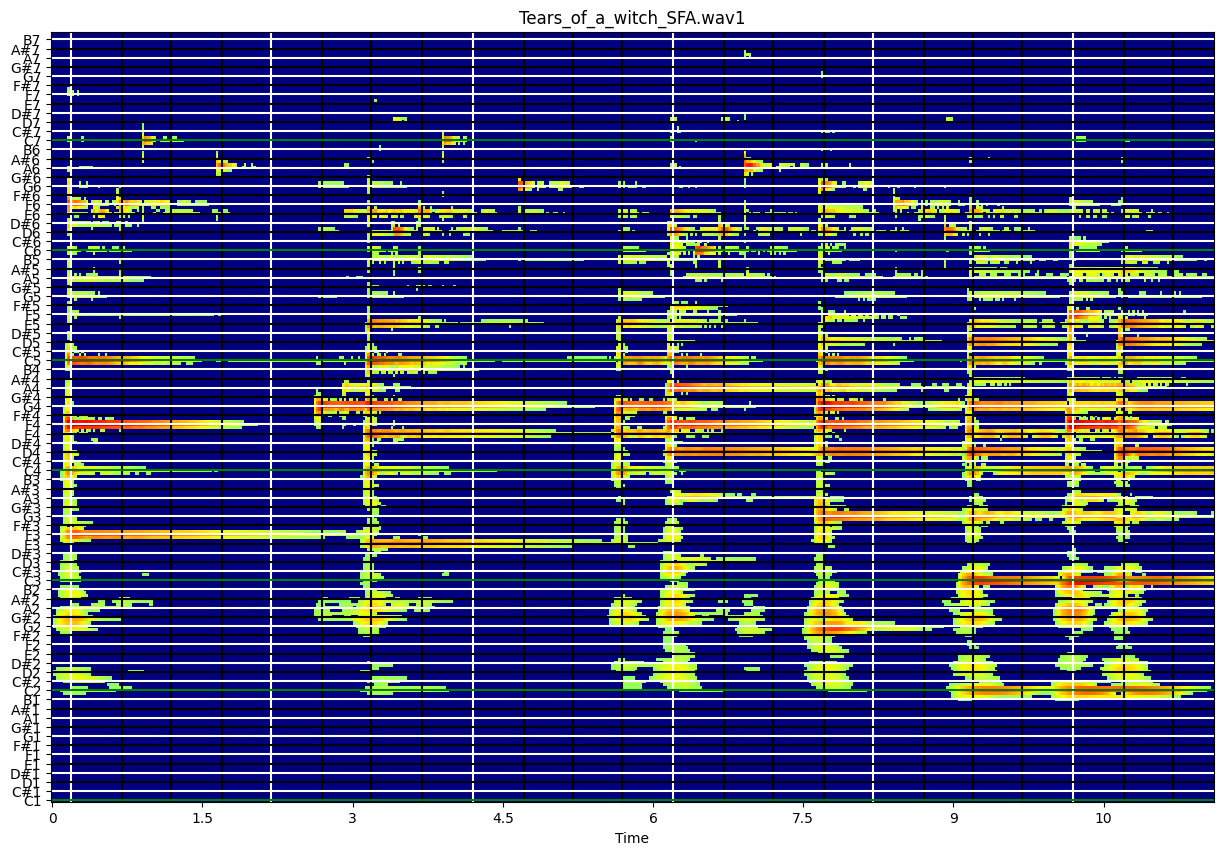

In [15]:
src = c_compression

cv2.namedWindow('spectrum', cv2.WINDOW_NORMAL)
cv2.createTrackbar('base_level','spectrum',0,255,nothing)

tmp = []
fn_log = []
idx = 1
crop = cqt_load(src,idx)
kw = 0
while True:
    hist = cv2.calcHist([crop], [0], None, [256], [1, 257])
    histImg = getGrayHistImage(hist)
    img_bgr = jet(crop)
    cv2.imshow('spectrum', img_bgr)
    cv2.imshow('histogram', histImg)
    
    kw=cv2.waitKey()
    pos = cv2.getTrackbarPos('base_level','spectrum')
    
    if kw==27:
        break
    elif kw==ord('z'):
        if fn_log==[]:
            crop = src.copy()            
            print('이전 작업이 없습니다.')           
        else:
            a = tmp.pop()
            crop = a
            fn_log.pop()
            print('실행취소',len(tmp),len(fn_log))
    elif kw==ord('r'):
        crop = cqt_load(src,idx)
        tmp = []
        fn_log = []
        print()
        print('-'*10)
        print("Reset")
        print('-'*10)
        print()
    elif iskw(kw):
        crop, fn_log = kw_fn(kw,crop,pos,fn_log)
    elif kw==ord('a'):
        print("auto repeat start")
        if fn_log==[]:
            continue
        else:
            crop = auto_fn(crop,fn_log)
        print("auto repeat end")
    elif kw==ord('n'):
        idx +=1
        if 250*idx > src.shape[1]:
            idx -=1
            print('end index')
        crop = cqt_load(src,idx)
    elif kw==ord('b'):
        idx -=1
        if idx < 1:
            idx = 1
        crop = cqt_load(src,idx)
    elif kw==ord('s'):
        frames = beat_frames[(250*(idx-1)<beat_frames)&(beat_frames<250*(idx+1))]-(250*(idx-1))
        beat_times = librosa.frames_to_time(frames, sr=sr)
        notes = ['C','','D','','E','','F#','','G#','','A#','']
        y_ticks = np.arange(0,12*freq_w*octave,freq_w)
        y_list=[]

        for o in range(octave):
            for i in range(12):
                y_list.append(notes[i]+'%d'%(o+1))

        plt.style.use('default')
        fig, ax = plt.subplots(1,1,figsize=(15,10))
        img = librosa.display.specshow(crop, sr=sr, x_axis='time', ax=ax, hop_length= hop_len, bins_per_octave= 12*freq_w,
                                    cmap='jet'
                                    )
        ax.set(title=filename+str(idx))
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_list)
        

        
        for i,v in zip(range(len(beat_times)),beat_times):
            if i % 4==0:
                ax.axvline(v,c='white')
            else:
                ax.axvline(v,c='k')
                
        for i in np.arange(0,12*freq_w*octave,freq_w):
            if i % (freq_w*12) ==0:
                ax.axhline(i,c='g')
            elif i % (freq_w*2) ==0:
                ax.axhline(i,c='k')
            else:
                ax.axhline(i,c='white')
            
        plt.savefig('./output/'+filename.split('.')[0]+str(idx))
        print(filename.split('.')[0]+str(idx),'save complete')
        plt.show()
    
    else:
        continue
        
    tmp.append(crop.copy())
    
        

cv2.destroyAllWindows()

In [10]:
y_ticks

array([  0,   3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,  36,
        39,  42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,  75,
        78,  81,  84,  87,  90,  93,  96,  99, 102, 105, 108, 111, 114,
       117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153,
       156, 159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192,
       195, 198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231,
       234, 237, 240, 243, 246, 249])